### ODE Integration (Runge-Kutta) | PDE Integration (Method of Lines)
**Author**: Ken Sible | **Date**: July 12, 2019

### General Runge-Kutta Method & Butcher Table
\begin{equation}
    y_{i+1}=y_i+\Delta t\sum_{i=1}^na_ik_i+O(\Delta t^{n+1})
\end{equation}
\begin{align*}
    k_1&=f(t_i,y_i)\\
    k_2&=f(t_i+p_2\Delta t,y_i+\Delta t(q_{21}k_1))\\
    k_3&=f(t_i+p_3\Delta t,y_i+\Delta t(q_{31}k_1+q_{32}k_2))\\
    \vdots\\
    k_n&=f(t_i+p_n\Delta t,y_i+\Delta t(q_{n1}k_1+q_{n2}k_2+\ldots+q_{n,n-1}k_{n-1}))
\end{align*}
<img src="images/butcher_table.png" width="362" height="237" align="center"/>

In [1]:
function RK2(t::Real, y::Array{<:Real}, f::Function, h::Real, args...)
    p = [0, 2/3]
    q = [0 0; 2/3 0]
    a = [1/4; 3/4]
    
    k1 = f(t, y, args...)
    k2 = f(t + p[2]*h, y + h*(q[2, 1]*k1), args...)
    return y + h*(a[1]*k1 + a[2]*k2)
end

function RK4(t::Real, y::Array{<:Real}, f::Function, h::Real, args...)
    p = [0, 1/2, 1/2, 1]
    q = [0 0 0 0; 1/2 0 0 0; 0 1/2 0 0; 0 0 1 0]
    a = [1/6, 1/3, 1/3, 1/6]
    
    k1 = f(t, y, args...)
    k2 = f(t + p[2]*h, y + h*(q[2, 1]*k1), args...)
    k3 = f(t + p[3]*h, y + h*(q[3, 1]*k1 + q[3, 2]*k2), args...)
    k4 = f(t + p[4]*h, y + h*(q[4, 1]*k1 + q[4, 2]*k2 + q[4, 3]*k3), args...)
    return y + h*(a[1]*k1 + a[2]*k2 + a[3]*k3 + a[4]*k4)
end;

### ODE Integrator (Runge-Kutta)

In [2]:
function odeint(f::Function, tspan::NTuple{2, Real}, y0::Vector{<:Real}, 
        h::Real, args...; tol::Real=1e-8, max_step::Real=Inf, method::Symbol=:RK4)
    if method == :RKF45
        i, t, y = 1, [tspan[1]], y0
        while t[i] < tspan[2]
            if (t[i] + h) > tspan[2]
                h = tspan[2] - t[i]
            end
            y_tmp, res = RKF45(t[i], y[:, i], f, h, args...)
            ε = norm(res)
            if ε < tol
                y = hcat(y, y_tmp)
                t = vcat(t, t[i] + h)
                i += 1
            end
            h *= 0.9(tol/ε)^(1/4)
            if h > max_step
                h = max_step
            end
        end
        y = permutedims(y)
    else
        RK = method ∈ (:RK2, :RK4) ? eval(method) : 
            error("Unsupported Runge-Kutta Method")
        t = collect(tspan[1]:h:tspan[2])
        y = zeros(length(t), length(y0))
        y[1, :] = y0 # Initial Condition
        for i = 1:(length(t) - 1)
            y[i + 1, :] = RK(t[i], y[i, :], f, h, args...)
        end
    end
    return t, y
end;

In [3]:
function downsize(u0::Vector{<:Real}, N::Int=1)
    size::Int = (length(u0) - 1)/2 + 1
    u = [u0[2i - 1] for i = 1:size] 
    return N == 1 ? u : downsize(u, N - 1)
end

function convergence(u::NTuple{3, Vector{<:Real}})
    u_D1 = downsize(u[2])
    u_D2 = downsize(u[3], 2)
    return log2.(abs.((u[1] - u_D1)./(u_D1 - u_D2)))
end;

### Example: Initial Value Problem (ODE)
$$y''+y'+2y=0,\,0 \leq t \leq 25,\,y(0)=1,\,y'(0)=0$$

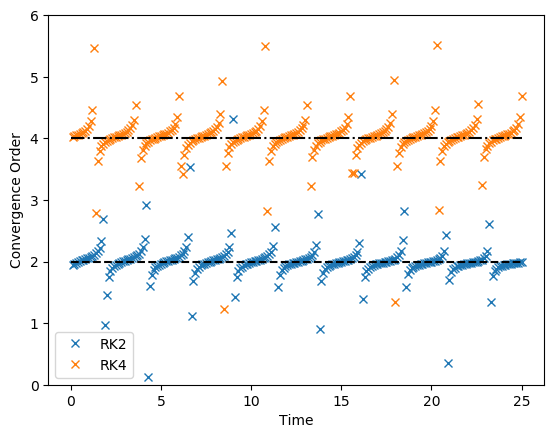

In [4]:
using PyPlot

f(t, x) = [x[2], -2 * x[1] - x[2]]

t1, y1 = odeint(f, (0, 25), [1, 0], 0.1, method=:RK2)
t2, y2 = odeint(f, (0, 25), [1, 0], 0.1/2, method=:RK2)
t3, y3 = odeint(f, (0, 25), [1, 0], 0.1/4, method=:RK2)
plot(t1, convergence((y1[:, 1], y2[:, 1], y3[:, 1])), "x", label="RK2")

t1, y1 = odeint(f, (0, 25), [1, 0], 0.1, method=:RK4)
t2, y2 = odeint(f, (0, 25), [1, 0], 0.1/2, method=:RK4)
t3, y3 = odeint(f, (0, 25), [1, 0], 0.1/4, method=:RK4)
plot(t1, convergence((y1[:, 1], y2[:, 1], y3[:, 1])), "x", label="RK4")

plot(t1, fill(2.0, length(t1)), "k--")
plot(t1, fill(4.0, length(t1)), "k-.")
plt.ylabel("Convergence Order"); plt.xlabel("Time")
plt.ylim(0, 6); plt.legend();

### Adaptive ODE Integrator (Embedded Runge-Kutta)
$$
\begin{align*}
y(t_n)-y_n&=O\left(h^k\right)\\
y(t_n)-y_n^*&=O\left(h^{k-1}\right)\\
\end{align*}
\Rightarrow\,|y_n-y_n^*|=O\left(h^{k-1}\right)\approx|C|h^{k-1}<T
$$
$$
\bar{h}=0.9h\left(\frac{T}{|y_n-y_n^*|}\right)^{1/{(k-1)}}
$$

In [5]:
function RKF45(t::Real, y::Array{<:Real}, f::Function, h::Real, args...)
    p = [0, 1/4, 3/8, 12/13, 1, 1/2]
    q = [0 0 0 0 0 0; 1/4 0 0 0 0 0; 3/32 9/32 0 0 0 0; 1932/2197 -7200/2197 7296/2197 0 0 0;
         439/216 -8 3680/513 -845/4104 0 0; -8/27 2 -3544/2565 1859/4104 -11/40 0]
    a = [16/135, 0, 6656/12825, 28561/56430, -9/50, 2/55]
    b = [25/216, 0, 1408/2565, 2197/4104, -1/5, 0]
    
    k1 = f(t, y, args...)
    k2 = f(t + p[2]*h, y + h*(q[2, 1]*k1), args...)
    k3 = f(t + p[3]*h, y + h*(q[3, 1]*k1 + q[3, 2]*k2), args...)
    k4 = f(t + p[4]*h, y + h*(q[4, 1]*k1 + q[4, 2]*k2 + q[4, 3]*k3), args...)
    k5 = f(t + p[5]*h, y + h*(q[5, 1]*k1 + q[5, 2]*k2 + q[5, 3]*k3 + q[5, 4]*k4), args...)
    k6 = f(t + p[6]*h, y + h*(q[6, 1]*k1 + q[6, 2]*k2 + q[6, 3]*k3 + q[6, 4]*k4 + q[6, 5]*k5), args...)
    y1 = y + h*(b[1]*k1 + b[2]*k2 + b[3]*k3 + b[4]*k4 + b[5]*k5 + b[6]*k6)
    y2 = y + h*(a[1]*k1 + a[2]*k2 + a[3]*k3 + a[4]*k4 + a[5]*k5 + a[6]*k6)
    return y2, (y2 - y1)
end;

### Example: *Adaptive* Initial Value Problem (ODE)
$$y''+y'+2y=0,\,0 \leq t \leq 25,\,y(0)=1,\,y'(0)=0$$

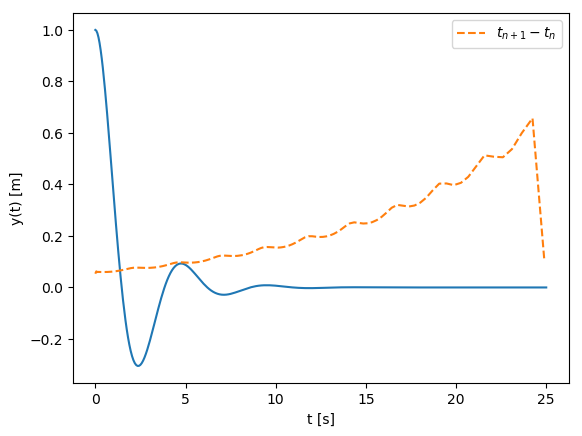

In [6]:
using PyPlot, LinearAlgebra

f(t, x) = [x[2], -2 * x[1] - x[2]]

t, y = odeint(f, (0, 25), [1, 0], 0.1, method=:RKF45); N = length(t)
plot(t, y[:, 1]); plt.ylabel("y(t) [m]"); plt.xlabel("t [s]")

h = [t[i + 1] - t[i] for i = 1:(N - 1)]
plot(t[1:(end - 1)], h, "--", label=L"t_{n+1}-t_n"); plt.legend();

### General Finite Difference Approximation
$$\frac{h^d}{d!}F^{(d)}(x)=\sum_{i=i_{min}}^{i_{max}}C_iF(x+ih)+O(h^{d+p})$$

In [7]:
struct FiniteDiff
    d::Integer
    p::Integer
    s::Vector{<:Integer}
    c::Vector{<:Real}
    h::Real
    function FiniteDiff(d, p, s, h)
        N, F = length(s), factorial(d)
        D = [d == (n - 1) ? 1 : 0 for n = 1:N] .* F
        M = [s[m]^(n - 1) for n = 1:N, m = 1:N]
        new(d, p, s, M\D, h)
    end
end

function (FD::FiniteDiff)(f::Vector, i::Int)
    approx = 0
    for n = 1:length(FD.s)
        approx += FD.c[n]*f[i + FD.s[n]]
    end
    return approx/FD.h^FD.d
end

function (FD::FiniteDiff)(f::Function, x::Real)
    approx = 0
    for n = 1:length(FD.s)
        approx += FD.c[n]*f(x + FD.s[n]*h)
    end
    return approx/FD.h^FD.d
end;

### Example: Finite Difference Derivatives
$$\varphi_{xx}=\frac{\varphi(x+h)-2\varphi(x)+\varphi(x-h)}{h^2}+O(h^2)$$

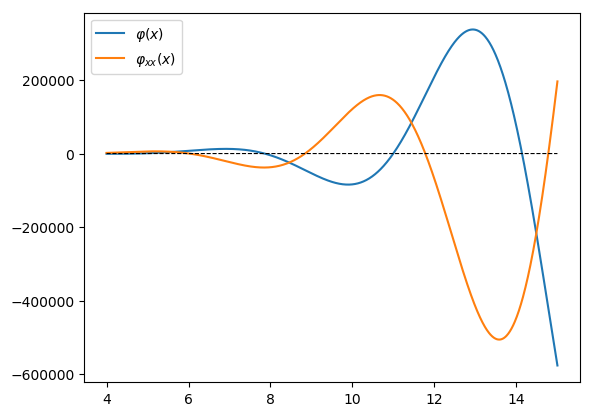

In [8]:
using PyPlot

φ(x) = (x^5 - 5x) * cos(x)
h = 0.01; x = 4:h:15
φxx_FD = FiniteDiff(2, 2, [-1, 0, 1], h)

plot(x, φ.(x), label=L"\varphi(x)")
plot(x, φxx_FD.(φ, x), label=L"\varphi_{xx}(x)")
plot(x, zeros(length(x)), "k--", linewidth=0.8)
plt.legend();

### PDE Integrator (Method of Lines)

In [9]:
function pdeint(f::Function, tspan::NTuple{2, Real}, xspan::NTuple{2, Real}, 
        u0::Array{<:Real}, ht::Real, hx::Real, args...; method::Symbol=:RK4)
    RK = method ∈ (:RK2, :RK4) ? eval(method) : 
        error("Unsupported Runge-Kutta Method")
    t = collect(tspan[1]:ht:tspan[2])
    x = collect(xspan[1]:hx:xspan[2])
    Nt, Nx = length(t), length(x)
    u = u0 # Initial Condition
    for i = 1:(Nt - 1)
        u = RK(t[i], u, f, ht, args...)
    end
    return x, u
end;

### Example: Advection Equation (PDE)
$$u_t+u_x=0,\,0 \leq t \leq 50,\,0 \leq x \leq 150,\,u(x,0)=0.5\,e^{-0.1(x - x_0)^2}$$

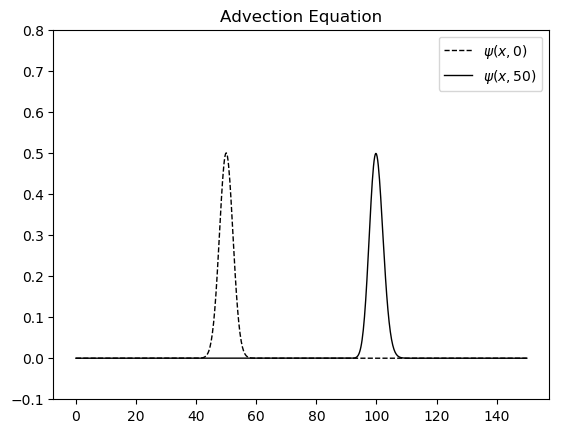

In [10]:
using PyPlot

hx, ht = 0.2, 0.04
x0, x = 50, collect(0:hx:150)
ψx_FD = FiniteDiff(1, 2, [-1, 1], hx)

function f(t, ψ)
    Nx = size(ψ)[1]
    ψx = zeros(Nx)
    for j = 2:(Nx - 1)
        ψx[j] = ψx_FD(ψ, j)
    end
    return -ψx
end

ψ0 = 0.5(exp.(-0.1(x .- x0).^2))

x, ψ = pdeint(f, (0, 50), (0, 150), ψ0, ht, hx);

plot(x, ψ0, "k--", label=L"\psi(x,0)", linewidth=1.0)
plot(x, ψ, "k", label=L"\psi(x,50)", linewidth=1.0)
plt.title("Advection Equation"); plt.ylim(-0.1, 0.8); plt.legend();

### Example: Wave Equation (PDE)
$$u_{tt}=u_{xx},\,0 \leq t \leq 50,\,0 \leq x \leq 150,\,u(x,0)=0.5\,e^{-0.1(x - x_0)^2},\,u_t(x,0)=0$$

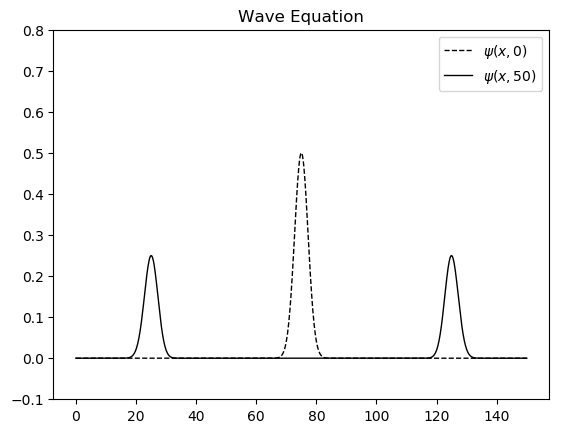

In [11]:
using PyPlot

hx, ht = 0.2, 0.04
x0, x = 75, collect(0:hx:150)
ψxx_FD = FiniteDiff(2, 2, [-1, 0, 1], hx)

function f(t, ψ)
    Nx = size(ψ)[1]
    ψxx = zeros(Nx)
    for j = 2:(Nx - 1)
        ψxx[j] = ψxx_FD(ψ[:, 1], j)
    end
    return hcat(ψ[:, 2], ψxx)
end

g(x) = 0.5(exp(-0.1(x - x0)^2))
ψ0 = hcat(g.(x), zeros(length(x)))

x, ψ = pdeint(f, (0, 50), (0, 150), ψ0, ht, hx);

plot(x, ψ0[:, 1], "k--", label=L"\psi(x,0)", linewidth=1.0)
plot(x, ψ[:, 1], "k", label=L"\psi(x,50)", linewidth=1.0)
plt.title("Wave Equation"); plt.ylim(-0.1, 0.8); plt.legend();

### Example: Diffusion Equation (PDE)
$$u_t=u_{xx},\,0 \leq t \leq 100,\,0 \leq x \leq 150,\,u(x,0)=\sin^4{\left(\frac{\pi}{150}x\right)},\,u(0,t)=u(150,t)=0$$

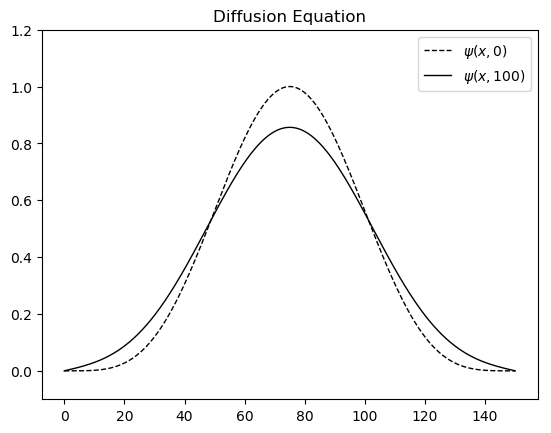

In [12]:
using PyPlot

hx, ht = 0.2, 0.01
x = collect(0:hx:150)
ψxx_FD = FiniteDiff(2, 2, [-1, 0, 1], hx)

function f(t, ψ)
    Nx = size(ψ)[1]
    ψxx = zeros(Nx)
    for j = 2:(Nx - 1)
        ψxx[j] = ψxx_FD(ψ, j)
    end
    return ψxx
end

ψ0 = (sin.((π/150)x)).^4

x, ψ = pdeint(f, (0, 100), (0, 150), ψ0, ht, hx)

plot(x, ψ0, "k--", label=L"\psi(x,0)", linewidth=1.0)
plot(x, ψ, "k", label=L"\psi(x,100)", linewidth=1.0)
plt.title("Diffusion Equation"); plt.ylim(-0.1, 1.2); plt.legend();